In [17]:
import gymnasium as gym
from pogema import GridConfig
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy

%load_ext autoreload
%autoreload 2
%matplotlib inline

grid_config = GridConfig(
    size=8,
    density=0.3,
    num_agents=1,
    max_episode_steps=30
)

env = gym.make("Pogema-v0",grid_config=grid_config)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/bernard/miniconda3/envs/rlenv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:29: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
/home/bernard/miniconda3/envs/rlenv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:34: UserWarning: WARN: It seems a Box observation space is an image but the lower and upper bounds are not [0, 255]. Actual lower bound: -1.0, upper bound: 1.0. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(


### DQN

Sources: 

* https://github.com/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/dqn_sb3.ipynb
* https://github.com/araffin/rl-tutorial-jnrr19/blob/sb3/1_getting_started.ipynb

In [18]:
dqn_model = DQN(
    "MlpPolicy",
    env,
    verbose=1,
    train_freq=16,
    gradient_steps=8,
    gamma=0.99,
    exploration_fraction=0.2,
    exploration_final_eps=0.07,
    target_update_interval=600,
    learning_starts=1000,
    buffer_size=10000,
    batch_size=128,
    learning_rate=4e-3,
    policy_kwargs=dict(net_arch=[256, 256]),
    seed=42,
)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [19]:
# Evaluate untrained agent using separate env

val_env = gym.make("Pogema-v0",grid_config=grid_config)

val_dqn_model = DQN(
    "MlpPolicy",
    val_env,
    verbose=1,
    train_freq=16,
    gradient_steps=8,
    gamma=0.99,
    exploration_fraction=0.2,
    exploration_final_eps=0.07,
    target_update_interval=600,
    learning_starts=1000,
    buffer_size=10000,
    batch_size=128,
    learning_rate=4e-3,
    policy_kwargs=dict(net_arch=[256, 256]),
    seed=42,
)

mean_reward, std_reward = evaluate_policy(
    val_dqn_model,
    val_dqn_model.get_env(),
    deterministic=True,
    n_eval_episodes=20,
)

print(f"mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
mean_reward: 0.00 +/- 0.00


In [20]:
# Train agent and save it
dqn_model.learn(total_timesteps=int(3.0e5))
dqn_model.save("saved/dqn_baseline")

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26       |
|    ep_rew_mean      | 0.25     |
|    exploration_rate | 0.998    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 10771    |
|    time_elapsed     | 0        |
|    total_timesteps  | 104      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.2     |
|    ep_rew_mean      | 0.375    |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 10473    |
|    time_elapsed     | 0        |
|    total_timesteps  | 186      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.5     |
|    ep_rew_mean      | 0.25     |
|    exploration_rate | 0.995    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 11096    |
|    time_elapsed     | 0        |
|    total_timesteps  | 306      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.9     |
|    ep_rew_mean      | 0.25     |
|    exploration_rate | 0.994    |
| time/               |          |
|    episodes       

### Load trained agent and evaluate it

In [30]:
dqn_model = DQN.load("saved/dqn_baseline")

env.reset()

mean_reward, std_reward = evaluate_policy(dqn_model, env, deterministic=True, n_eval_episodes=20)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:0.05 +/- 0.22


### Video Recording

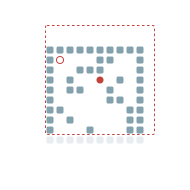

In [31]:
from IPython.display import SVG, display
from pogema.animation import AnimationMonitor, AnimationConfig

env = AnimationMonitor(env)

obs, info = env.reset()

# terminated = truncated = [False, ...]

# while not all(terminated) and not all(truncated):
#     # Use random policy to make actions
#     obs, reward, terminated, truncated, info = env.step([env.action_space.sample() for _ in range(grid_config.num_agents)])

terminated = truncated = False

while not terminated or not truncated:
    action, _states = dqn_model.predict(obs)
    # obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
    obs, reward, terminated, truncated, info = env.step(action)

env.save_animation("renders/render.svg", AnimationConfig(egocentric_idx=0))
display(SVG('renders/render.svg'))